## Instructions to run this notebook

In this notebook, we present the comparisons for HB-MNIST: Confounded and anti-causal colored MNIST.
Run all the cells sequentially from top to bottom; we have commented the cells to help the reader.

## Libraries

In [1]:
import tensorflow as tf
import numpy as np
import argparse
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import pandas as pd
# import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import cProfile
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.model_selection import KFold
from datetime import date
import time

In [2]:
from data_construct import * ## contains functions for constructing data 
from IRM_methods import *    ## contains IRM and ERM methods 

## Sample complexity on HB-CMNIST

In [4]:

n_trial =10
n_tr_list = [ 1000,5000, 10000, 30000, 60000] # list of training sample sizes

k=0
K = len(n_tr_list)
ERM_model_acc = np.zeros((K,n_trial))
ERM_model_acc_nb = np.zeros((K,n_trial))
IRM_model_acc = np.zeros((K,n_trial))
IRM_model_acc_v = np.zeros((K,n_trial))

ERM_model_acc1 = np.zeros((K,n_trial))
ERM_model_acc1_nb = np.zeros((K,n_trial))
IRM_model_acc1 = np.zeros((K,n_trial))
IRM_model_acc1_v = np.zeros((K,n_trial))
IRM_model_ind_v = np.zeros((K,n_trial))

ERM_model_acc_av = np.zeros(K)
ERM_model_acc_av_nb = np.zeros(K)
IRM_model_acc_av = np.zeros(K)
IRM_model_acc_av_v = np.zeros(K)


ERM_model_acc_av1 = np.zeros(K)
ERM_model_acc_av1_nb = np.zeros(K)
IRM_model_acc_av1 = np.zeros(K)
IRM_model_acc_av1_v = np.zeros(K)

list_params = []
for n_tr in n_tr_list:
    print ("tr" + str(n_tr))
#     print ("start")
    t_start = time.time()
    for trial in range(n_trial):
        print ("trial " + str(trial))
        n_e=2
        p_color_list = [0.2, 0.1]
        p_label_list = [0.25]*n_e
        D = assemble_data_mnist_confounded_child(n_tr) # initialize mnist digits data object

        D.create_training_data(n_e, p_color_list, p_label_list) # creates the training environments

        p_label_test = 0.25 # probability of switching pre-label in test environment
        p_color_test = 0.9  # probability of switching the final label to obtain the color index in test environment

        D.create_testing_data(p_color_test, p_label_test, n_e)  # sets up the testing environment
        (num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
        num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

        model_erm =  keras.Sequential([
                keras.layers.Flatten(input_shape=(length,width,height)),
                keras.layers.Dense(390, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(390, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(2, activation='softmax')
        ])
        
        num_epochs = 100
        batch_size = 512
        learning_rate = 4.9e-4
        erm_model1 = standard_erm_model(model_erm, num_epochs, batch_size, learning_rate)
        erm_model1.fit(D.data_tuple_list)
        erm_model1.evaluate(D.data_tuple_test)
        print ("Training accuracy:" + str(erm_model1.train_acc))
        print ("Testing accuracy:" + str(erm_model1.test_acc))
        
        ERM_model_acc[k][trial] = erm_model1.test_acc
        ERM_model_acc1[k][trial] = erm_model1.train_acc


#         gamma_list = [10000, 33000, 66000,100000.0]
        gamma_list = [100000]
        index=0
        best_err = 1e6
        train_list =[]
        val_list = []
        test_list = []
        for gamma_new in gamma_list:

            model_irm = keras.Sequential([
                                keras.layers.Flatten(input_shape=(length,width,height)),
                                keras.layers.Dense(390, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                                keras.layers.Dense(390, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                                keras.layers.Dense(num_classes)
                        ])
            batch_size       = 512
            steps_max        = 1000
            steps_threshold  = 190  ## threshold after which gamma_new is used
            learning_rate    = 4.9e-4


            irm_model1 = irm_model(model_irm, learning_rate, batch_size, steps_max, steps_threshold, gamma_new)
            irm_model1.fit(D.data_tuple_list)
            irm_model1.evaluate(D.data_tuple_test)
            error_val = 1-irm_model1.val_acc
            train_list.append(irm_model1.train_acc)
            val_list.append(irm_model1.val_acc)
            test_list.append(irm_model1.test_acc)
            if(error_val<best_err):
                index_best =index
                best_err = error_val
            index= index+1

        print ("Training accuracy:" + str(train_list[index_best]))
        print ("Validation accuracy:" + str(val_list[index_best]))
        print ("Testing accuracy:" + str(test_list[index_best]))

        IRM_model_acc_v[k][trial]  = test_list[index_best]
        IRM_model_acc1_v[k][trial] = train_list[index_best]
        IRM_model_ind_v[k][trial]  = index_best


    IRM_model_acc_av_v[k] = np.mean(IRM_model_acc_v[k])
    list_params.append([n_tr,"IRMv_test", np.mean(IRM_model_acc_v[k]),np.std(IRM_model_acc_v[k])])

    ERM_model_acc_av[k] = np.mean(ERM_model_acc[k])
    list_params.append([n_tr,"ERM_test", np.mean(ERM_model_acc[k]),np.std(ERM_model_acc[k])])


    IRM_model_acc_av1_v[k] = np.mean(IRM_model_acc1_v[k])
    list_params.append([n_tr,"IRMv_train", np.mean(IRM_model_acc1_v[k]),np.std(IRM_model_acc1_v[k])])
    
    ERM_model_acc_av1[k] = np.mean(ERM_model_acc1[k])
    list_params.append([n_tr, "ERM_train", np.mean(ERM_model_acc1[k]),np.std(ERM_model_acc1[k])])


    k=k+1

    t_end = time.time()
    print("total time: " + str(t_end-t_start))
results = pd.DataFrame(list_params, columns= ["Sample","Method", "Performance", "Sdev"])
ideal_error = np.ones(5)*0.25

tr1000
trial 0
60000
(232,)
(268,)
(225,)
(275,)
(5441,)
(4559,)
Epoch 1/100
1000/1000 [==============================] - 1s 749us/sample - loss: 1.7436 - acc: 0.6440
Epoch 2/100
1000/1000 [==============================] - 0s 46us/sample - loss: 1.6325 - acc: 0.7630
Epoch 3/100
1000/1000 [==============================] - 0s 51us/sample - loss: 1.5921 - acc: 0.7660
Epoch 4/100
1000/1000 [==============================] - 0s 57us/sample - loss: 1.5272 - acc: 0.7740
Epoch 5/100
1000/1000 [==============================] - 0s 54us/sample - loss: 1.4850 - acc: 0.7740
Epoch 6/100
1000/1000 [==============================] - 0s 66us/sample - loss: 1.4502 - acc: 0.7900
Epoch 7/100
1000/1000 [==============================] - 0s 64us/sample - loss: 1.4065 - acc: 0.8000
Epoch 8/100
1000/1000 [==============================] - 0s 61us/sample - loss: 1.3620 - acc: 0.8080
Epoch 9/100
1000/1000 [==============================] - 0s 56us/sample - loss: 1.3267 - acc: 0.8020
Epoch 10/100
1000/1000 [=

1000/1000 [==============================] - 0s 63us/sample - loss: 0.2688 - acc: 0.9980
Epoch 81/100
1000/1000 [==============================] - 0s 61us/sample - loss: 0.2662 - acc: 0.9980
Epoch 82/100
1000/1000 [==============================] - 0s 47us/sample - loss: 0.2623 - acc: 0.9980
Epoch 83/100
1000/1000 [==============================] - 0s 61us/sample - loss: 0.2582 - acc: 0.9980
Epoch 84/100
1000/1000 [==============================] - 0s 60us/sample - loss: 0.2550 - acc: 0.9980
Epoch 85/100
1000/1000 [==============================] - 0s 44us/sample - loss: 0.2514 - acc: 0.9980
Epoch 86/100
1000/1000 [==============================] - 0s 54us/sample - loss: 0.2488 - acc: 0.9970
Epoch 87/100
1000/1000 [==============================] - 0s 67us/sample - loss: 0.2442 - acc: 0.9980
Epoch 88/100
1000/1000 [==============================] - 0s 63us/sample - loss: 0.2421 - acc: 0.9980
Epoch 89/100
1000/1000 [==============================] - 0s 57us/sample - loss: 0.2389 - acc: 

5000/5000 [==============================] - 0s 63us/sample - loss: 0.1740 - acc: 0.9918
Epoch 58/100
5000/5000 [==============================] - 0s 61us/sample - loss: 0.1718 - acc: 0.9932
Epoch 59/100
5000/5000 [==============================] - 0s 67us/sample - loss: 0.1725 - acc: 0.9924
Epoch 60/100
5000/5000 [==============================] - 0s 68us/sample - loss: 0.1662 - acc: 0.9934
Epoch 61/100
5000/5000 [==============================] - 0s 67us/sample - loss: 0.1647 - acc: 0.9922
Epoch 62/100
5000/5000 [==============================] - 0s 60us/sample - loss: 0.1642 - acc: 0.9940
Epoch 63/100
5000/5000 [==============================] - 0s 62us/sample - loss: 0.1614 - acc: 0.9926
Epoch 64/100
5000/5000 [==============================] - 0s 57us/sample - loss: 0.1585 - acc: 0.9928
Epoch 65/100
5000/5000 [==============================] - 0s 58us/sample - loss: 0.1606 - acc: 0.9916
Epoch 66/100
5000/5000 [==============================] - 0s 51us/sample - loss: 0.1597 - acc: 

10000/10000 [==============================] - 1s 63us/sample - loss: 0.2062 - acc: 0.9825
Epoch 35/100
10000/10000 [==============================] - 1s 61us/sample - loss: 0.1998 - acc: 0.9844
Epoch 36/100
10000/10000 [==============================] - 1s 62us/sample - loss: 0.1976 - acc: 0.9842
Epoch 37/100
10000/10000 [==============================] - 1s 69us/sample - loss: 0.2007 - acc: 0.9822
Epoch 38/100
10000/10000 [==============================] - 1s 59us/sample - loss: 0.2009 - acc: 0.9814
Epoch 39/100
10000/10000 [==============================] - 1s 61us/sample - loss: 0.1934 - acc: 0.9834
Epoch 40/100
10000/10000 [==============================] - 1s 66us/sample - loss: 0.1850 - acc: 0.9840
Epoch 41/100
10000/10000 [==============================] - 1s 65us/sample - loss: 0.1798 - acc: 0.9866
Epoch 42/100
10000/10000 [==============================] - 1s 61us/sample - loss: 0.1772 - acc: 0.9861
Epoch 43/100
10000/10000 [==============================] - 1s 62us/sample - 

30000/30000 [==============================] - 2s 66us/sample - loss: 0.4779 - acc: 0.8151
Epoch 11/100
30000/30000 [==============================] - 2s 62us/sample - loss: 0.4656 - acc: 0.8198
Epoch 12/100
30000/30000 [==============================] - 2s 61us/sample - loss: 0.4541 - acc: 0.8225
Epoch 13/100
30000/30000 [==============================] - 2s 60us/sample - loss: 0.4455 - acc: 0.8261
Epoch 14/100
30000/30000 [==============================] - 2s 67us/sample - loss: 0.4371 - acc: 0.8296
Epoch 15/100
30000/30000 [==============================] - 2s 63us/sample - loss: 0.4236 - acc: 0.8364
Epoch 16/100
30000/30000 [==============================] - 2s 62us/sample - loss: 0.4185 - acc: 0.8379
Epoch 17/100
30000/30000 [==============================] - 2s 64us/sample - loss: 0.4136 - acc: 0.8419
Epoch 18/100
30000/30000 [==============================] - 2s 61us/sample - loss: 0.4020 - acc: 0.8498
Epoch 19/100
30000/30000 [==============================] - 2s 65us/sample - 

30000/30000 [==============================] - 2s 69us/sample - loss: 0.1828 - acc: 0.9532
Epoch 89/100
30000/30000 [==============================] - 2s 66us/sample - loss: 0.1855 - acc: 0.9527
Epoch 90/100
30000/30000 [==============================] - 2s 67us/sample - loss: 0.1848 - acc: 0.9524
Epoch 91/100
30000/30000 [==============================] - 2s 65us/sample - loss: 0.1829 - acc: 0.9539
Epoch 92/100
30000/30000 [==============================] - 2s 64us/sample - loss: 0.1829 - acc: 0.9537
Epoch 93/100
30000/30000 [==============================] - 2s 65us/sample - loss: 0.1886 - acc: 0.9505
Epoch 94/100
30000/30000 [==============================] - 2s 65us/sample - loss: 0.1854 - acc: 0.9529
Epoch 95/100
30000/30000 [==============================] - 2s 73us/sample - loss: 0.1848 - acc: 0.9535
Epoch 96/100
30000/30000 [==============================] - 2s 82us/sample - loss: 0.1921 - acc: 0.9496
Epoch 97/100
30000/30000 [==============================] - 2s 63us/sample - 

60000/60000 [==============================] - 4s 64us/sample - loss: 0.3276 - acc: 0.8780
Epoch 65/100
60000/60000 [==============================] - 4s 68us/sample - loss: 0.3225 - acc: 0.8802
Epoch 66/100
60000/60000 [==============================] - 5s 78us/sample - loss: 0.3231 - acc: 0.8816
Epoch 67/100
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3239 - acc: 0.8802
Epoch 68/100
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3217 - acc: 0.88130s - loss: 0.3201 - acc:
Epoch 69/100
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3171 - acc: 0.8827
Epoch 70/100
60000/60000 [==============================] - 4s 68us/sample - loss: 0.3197 - acc: 0.8822
Epoch 71/100
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3140 - acc: 0.8854
Epoch 72/100
60000/60000 [==============================] - 4s 65us/sample - loss: 0.3156 - acc: 0.8853
Epoch 73/100
60000/60000 [===========================

## Plot the results

(-0.01, 0.8)

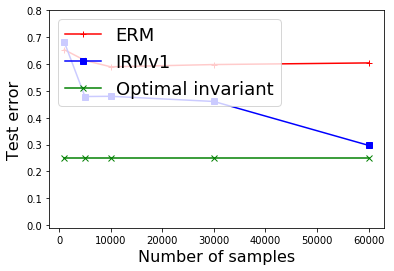

In [5]:
plt.figure()
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Test error", fontsize=16)
plt.plot(n_tr_list, 1-ERM_model_acc_av, "-r", marker="+", label="ERM")
plt.plot(n_tr_list, 1-IRM_model_acc_av_v, "-b", marker="s",label="IRMv1")
plt.plot(n_tr_list, ideal_error, "-g", marker="x", label="Optimal invariant")
plt.legend(loc="upper left", fontsize=18)
plt.ylim(-0.01,0.8)



In [ ]:
results